In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.optimizers import RMSprop, Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import keras.backend as K
import pickle
from tensorflow.keras.utils import to_categorical
from keras.layers import Input
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense,concatenate,add
)
from keras.optimizers import SGD
import glob
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
import seaborn as sns
from keras import Sequential
import math
import keras
from keras.preprocessing import image

## Loading Data

In [9]:
BASE_DIR = '../data/UTKFace/'

image_paths = []
age_labels = []
gender_labels = []


# file parse part modified from https://www.kaggle.com/code/eward96/age-and-gender-prediction-on-utkface
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
gender_dict = {0:'Male', 1:'Female'}

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)
        img = img.resize((32, 32), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    
    return features

X = extract_features(df['image'])
X = X/255.0

y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
x_gender_train = X[:14000]
y_gender_train = y_gender[:14000]
x_gender_va = X[13000:20000]
y_gender_va = y_gender[13000:20000]
x_gender_test = X[14000:20000]
y_gender_test = y_gender[14000:2000]

  0%|          | 0/23708 [00:00<?, ?it/s]

  0%|          | 0/23708 [00:00<?, ?it/s]

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_2551/197177837.py:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((32, 32), Image.ANTIALIAS)


In [6]:
X.shape

(23708, 32, 32, 3)

## Data Analysis

## Build Gender Network

In [5]:
def plot_loss_his(history):
    fig1 = plt.figure("Figure 1")
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("")
    plt.legend()
    plt.grid(True)
    
def plot_acc_his(history):
    fig1 = plt.figure("Figure 2")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.title("")
    plt.legend()
    plt.grid(True)

In [33]:
# n = 64,128,256,512
def residual_module(inputs, n):
   # 1x1 conv with n filters
    identity_layer = Conv2D(n, (1,1), activation='relu')(inputs)
    
    conv_1 = Conv2D(n, kernel_size=(1, 1), activation='relu',padding='same') (inputs)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_2 = Conv2D(n, kernel_size=(3, 3), activation='relu',padding='same') (conv_1)
    conv_2 = layers.BatchNormalization()(conv_2)
    conv_3 = Conv2D(n, kernel_size=(1, 1), activation='relu',padding='same') (conv_2)
    conv_3 = layers.BatchNormalization()(conv_3)
  
    out = add([conv_2, identity_layer])
    out = Activation('relu')(out)
    return out

input_shape = (32, 32, 3)
inputs = Input((input_shape))

#pre-conv layer
pre_conv = Conv2D(64,(7,7),activation='relu',padding='same')(inputs)
pre_layer = MaxPooling2D(pool_size=(3, 3))(pre_conv)


# Level 1 of residual, 32 conv filters
L1 = residual_module(pre_layer, 32)

# # Level 2 of residual, 64 conv filters
L2 = residual_module(L1, 64)

# # Level 3 of residual, 128 conv filters
L3 = residual_module(L2, 128)

# # Level 4 of residual, 256 conv filters
L4 = residual_module(L3, 256)


# Outer level of residual block
L0_identity = Conv2D(256, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(pre_layer)
bottleneck = add([L4, L0_identity])
bottleneck = Activation('relu')(bottleneck)
bottleneck = layers.BatchNormalization()(bottleneck)


# max pooling
bottleneck = layers.MaxPooling2D(pool_size=(4, 4))(bottleneck)
flatten = Flatten() (bottleneck)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)


dropout_1 = Dropout(0.5) (dense_1)
dropout_1 = Dropout(0.5) (dropout_1)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)


gender_model = Model(inputs=inputs, outputs=output_1)

gender_model.compile(optimizer="adam", 
              loss={
                  'gender_out': 'binary_crossentropy'},
              metrics={       
                  'gender_out': 'accuracy'})
gender_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_78 (Conv2D)             (None, 32, 32, 64)   9472        ['input_7[0][0]']                
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 10, 10, 64)  0           ['conv2d_78[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_80 (Conv2D)             (None, 10, 10, 32)   2080        ['max_pooling2d_14[0][0]'] 

 activation_24 (Activation)     (None, 10, 10, 256)  0           ['add_24[0][0]']                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 10, 10, 256)  1024       ['activation_24[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 2, 2, 256)   0           ['batch_normalization_72[0][0]'] 
 )                                                                                                
                                                                                                  
 flatten_6 (Flatten)            (None, 1024)         0           ['max_pooling2d_15[0][0]']       
                                                                                                  
 dense_6 (

In [34]:
# train model
history = gender_model.fit(x=x_gender_train, y=y_gender_train, batch_size=64, epochs=20, validation_data=[x_gender_va,y_gender_va])
gender_model.save("../data/gender_model")

Epoch 1/20


2022-11-09 10:36:37.683703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.6785

2022-11-09 10:36:51.702996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 18s 77ms/step - loss: 0.7542 - accuracy: 0.6785 - val_loss: 0.6733 - val_accuracy: 0.5855
Epoch 2/20
219/219 [==============================] - 16s 71ms/step - loss: 0.4388 - accuracy: 0.7921 - val_loss: 0.6107 - val_accuracy: 0.6648
Epoch 3/20
219/219 [==============================] - 15s 68ms/step - loss: 0.3619 - accuracy: 0.8391 - val_loss: 0.5253 - val_accuracy: 0.7659
Epoch 4/20
219/219 [==============================] - 14s 64ms/step - loss: 0.3270 - accuracy: 0.8551 - val_loss: 0.3804 - val_accuracy: 0.8496
Epoch 5/20
219/219 [==============================] - 14s 65ms/step - loss: 0.2886 - accuracy: 0.8721 - val_loss: 0.3523 - val_accuracy: 0.8498
Epoch 6/20
219/219 [==============================] - 15s 66ms/step - loss: 0.2640 - accuracy: 0.8833 - val_loss: 0.4582 - val_accuracy: 0.8414
Epoch 7/20
219/219 [==============================] - 14s 63ms/step - loss: 0.2483 - accuracy: 0.8931 - val_loss: 0.4623 - val_accuracy: 0.7709
Epo

INFO:tensorflow:Assets written to: ../data/gender_model/assets


INFO:tensorflow:Assets written to: ../data/gender_model/assets


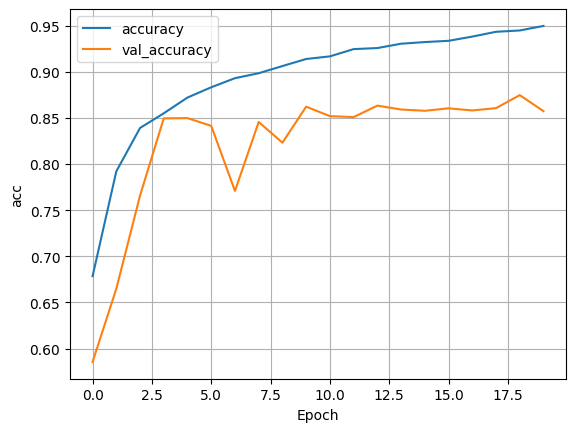

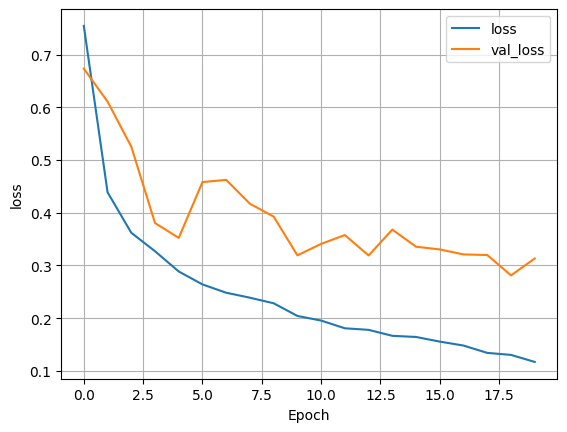

In [43]:
plot_acc_his(history)
plot_loss_his(history)

In [86]:
gender_model = tf.keras.models.load_model("../data/gender_model")
gender_model.evaluate(x=x_gender_test, y=y_gender_test)

2022-11-09 13:01:28.760790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


304/304 [==============================] - 4s 12ms/step - loss: 0.3244 - accuracy: 0.8496


[0.32444193959236145, 0.8496085405349731]

## Build Age network

In [10]:
BASE_DIR = '../data/UTKFace/'

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
gender_dict = {0:'Male', 1:'Female'}
df.sample(frac=1)

  0%|          | 0/23708 [00:00<?, ?it/s]

,image,age,gender
22277,../data/UTKFace/2_1_3_20161219225003319.jpg.ch...,2,1
6593,../data/UTKFace/4_1_3_20161219230403672.jpg.ch...,4,1
229,../data/UTKFace/26_0_1_20170116182128259.jpg.c...,26,0
2266,../data/UTKFace/39_0_0_20170116224630532.jpg.c...,39,0
18978,../data/UTKFace/27_1_0_20170119194402442.jpg.c...,27,1
...,...,...,...
7061,../data/UTKFace/53_0_0_20170117190917315.jpg.c...,53,0
6273,../data/UTKFace/54_0_4_20170103210718779.jpg.c...,54,0
23291,../data/UTKFace/5_1_0_20170109194113052.jpg.ch...,5,1
23601,../data/UTKFace/18_1_4_20161223230852802.jpg.c...,18,1


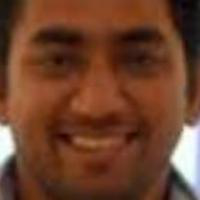

In [11]:
display(Image.open(df['image'][19]))

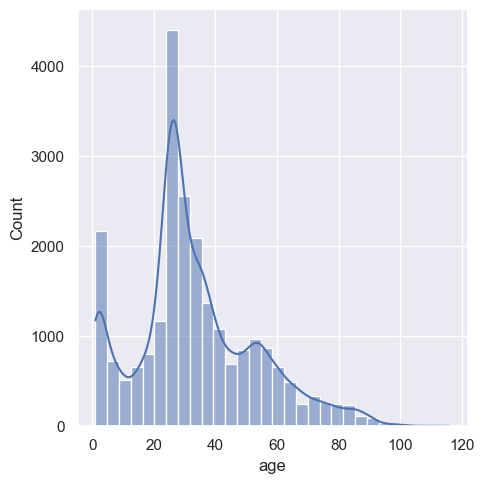

In [12]:
sns.set_theme()
sns.displot(df['age'],kde=True, bins=30)

In [13]:
age24_28 = []
for i in range(len(df)):
    if df['age'].iloc[i] >=24 and df['age'].iloc[i] <=28:
        age24_28.append(df.iloc[i])
age24_28 = pd.DataFrame(age24_28)
age24_28 = age24_28.sample(frac=0.3)

df1 = df[df['age'] <24]
df2 = df[df['age'] >28]
df = pd.concat([df1,df2, age24_28], ignore_index = True)

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_2551/1167467153.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'],kde=True, bins=30)


<AxesSubplot: xlabel='age', ylabel='Density'>

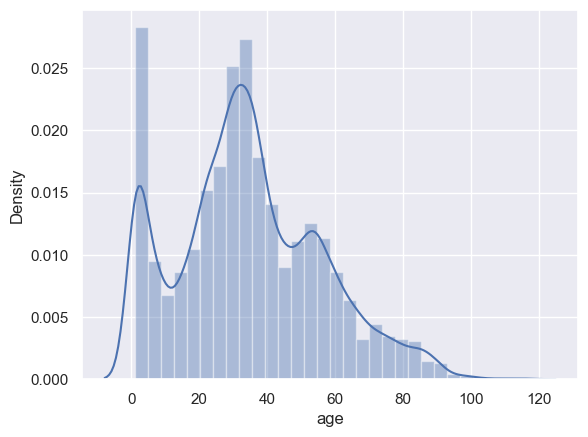

In [14]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [15]:
df = df[df['age']<=60]

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_2551/1167467153.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'],kde=True, bins=30)


<AxesSubplot: xlabel='age', ylabel='Density'>

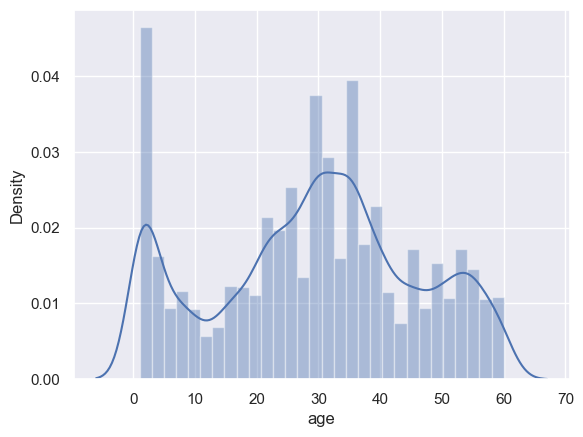

In [16]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [17]:
age_under4 = []
for i in range(len(df)):
    if df['age'].iloc[i] <=4:
        age_under4.append(df.iloc[i])
age_under4 = pd.DataFrame(age_under4)
age_under4 = age_under4.sample(frac=0.5)

df1 = df[df['age'] >4]
df = pd.concat([df1, age_under4], ignore_index = True)

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_2551/1167467153.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'],kde=True, bins=30)


<AxesSubplot: xlabel='age', ylabel='Density'>

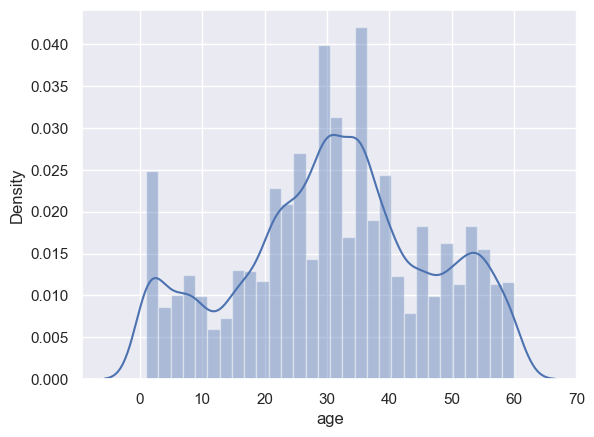

In [18]:
sns.set_theme()
sns.distplot(df['age'],kde=True, bins=30)

In [19]:
# train, validate data split
X = extract_features(df['image'])
X = X/255.0
y_age = np.array(df['age'])

age_off = 5
num_group = 60//age_off
age_group = []

for i in range(len(y_age)):
    group_num = int(math.ceil(y_age[i]/age_off))
    age_group.append(group_num)
    
y_age = np.array(age_group)
y_age = to_categorical(y_age)


  0%|          | 0/16502 [00:00<?, ?it/s]

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_2551/197177837.py:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((32, 32), Image.ANTIALIAS)


<AxesSubplot: xlabel='gender', ylabel='age'>

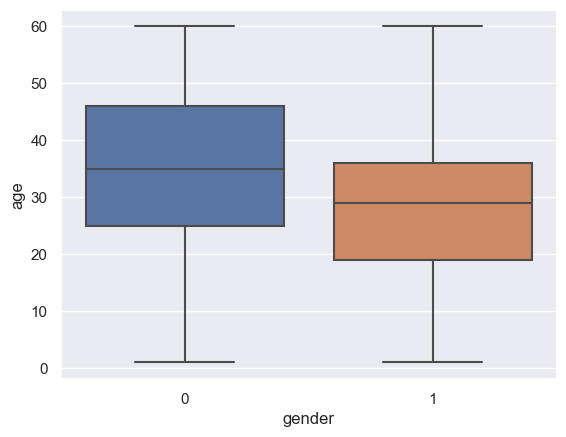

In [20]:
sns.boxplot(data=df, x='gender', y='age')

In [21]:
x_age_train = X[:14000]
y_age_train = y_age[:14000]
x_age_va = X[11000:14500]
y_age_va = y_age[11000:14500]
x_age_test = x_age_va
y_age_test = y_age_va


inputs = Input((32,32,3))
conv1 = keras.layers.Conv2D(filters = 16 , kernel_size = (3,3) , padding = 'same' , activation = 'relu') (inputs)
conv1 = layers.BatchNormalization()(conv1)
maxpool1 = keras.layers.MaxPool2D((2,2)) (conv1)

conv2 = keras.layers.Conv2D(filters = 32 , kernel_size = (3,3) , padding = 'same' , activation = 'relu') (maxpool1)
conv2 = layers.BatchNormalization()(conv2)
maxpool2 = keras.layers.MaxPool2D((2,2)) (conv2)


conv3 = keras.layers.Conv2D(filters = 64 , kernel_size = (3,3) , padding = 'same' , activation = 'relu') (maxpool2)
conv3 = layers.BatchNormalization()(conv3)
maxpool3 = keras.layers.MaxPool2D((2,2)) (conv3)

# Flatten

flatten = keras.layers.Flatten()(maxpool3)

# Dense Layer

dense = keras.layers.Dense(128 , activation = 'relu') (flatten)

dense = layers.BatchNormalization()(dense)
drop = keras.layers.Dropout(0.4) (dense)

# Output 

output = keras.layers.Dense(num_group+1, activation = 'softmax' , name = 'gender_output') (drop)




age_model =  keras.models.Model(inputs=[inputs], outputs = [output])

age_model.compile(
    optimizer=  'adam',
    loss= 'categorical_crossentropy',
    metrics = 'accuracy'
)

2022-11-10 11:06:33.716487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-10 11:06:33.717655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [22]:
X.shape

(16502, 32, 32, 3)

In [66]:
history = age_model.fit(x= x_age_train , y = y_age_train, batch_size=64, epochs=50, validation_data=(x_age_va, y_age_va))
age_model.save("../data/age_model")

Epoch 1/50


2022-11-09 11:33:57.050604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 2.6098 - accuracy: 0.1691

2022-11-09 11:34:01.877430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 6s 24ms/step - loss: 2.6098 - accuracy: 0.1691 - val_loss: 4.2265 - val_accuracy: 0.0380
Epoch 2/50
219/219 [==============================] - 4s 20ms/step - loss: 2.1026 - accuracy: 0.2500 - val_loss: 2.0192 - val_accuracy: 0.2583
Epoch 3/50
219/219 [==============================] - 4s 20ms/step - loss: 1.9327 - accuracy: 0.2822 - val_loss: 1.8073 - val_accuracy: 0.2986
Epoch 4/50
219/219 [==============================] - 4s 19ms/step - loss: 1.8109 - accuracy: 0.3192 - val_loss: 2.3790 - val_accuracy: 0.2106
Epoch 5/50
219/219 [==============================] - 4s 19ms/step - loss: 1.7343 - accuracy: 0.3480 - val_loss: 1.6966 - val_accuracy: 0.3357
Epoch 6/50
219/219 [==============================] - 4s 19ms/step - loss: 1.6624 - accuracy: 0.3724 - val_loss: 1.7034 - val_accuracy: 0.3517
Epoch 7/50
219/219 [==============================] - 4s 19ms/step - loss: 1.6047 - accuracy: 0.3901 - val_loss: 1.5688 - val_accuracy: 0.4009
Epoch 8/50

INFO:tensorflow:Assets written to: ../data/age_model/assets


INFO:tensorflow:Assets written to: ../data/age_model/assets


In [82]:
age_model = tf.keras.models.load_model("../data/age_model")
age_model.evaluate(x=x_age_test, y=y_age_test)

  3/110 [..............................] - ETA: 2s - loss: 0.0891 - accuracy: 0.9896 

2022-11-09 11:51:35.208083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 1s 11ms/step - loss: 0.8608 - accuracy: 0.8586


[0.8607784509658813, 0.8585714101791382]

In [404]:
def plot_loss_his(history):
    fig1 = plt.figure("Figure 1")
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("")
    plt.legend()
    plt.grid(True)
    
def plot_acc_his(history):
    fig1 = plt.figure("Figure 2")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    # plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.title("")
    plt.legend()
    plt.grid(True)

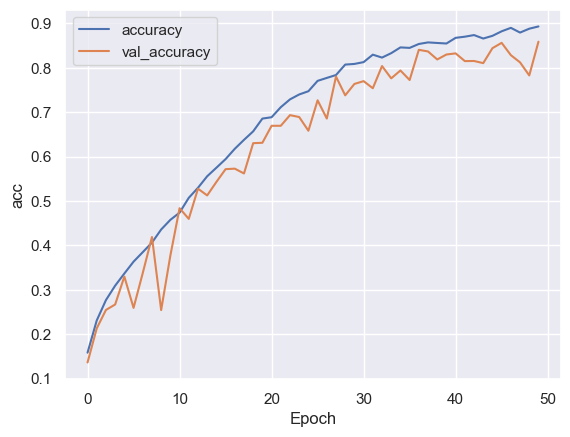

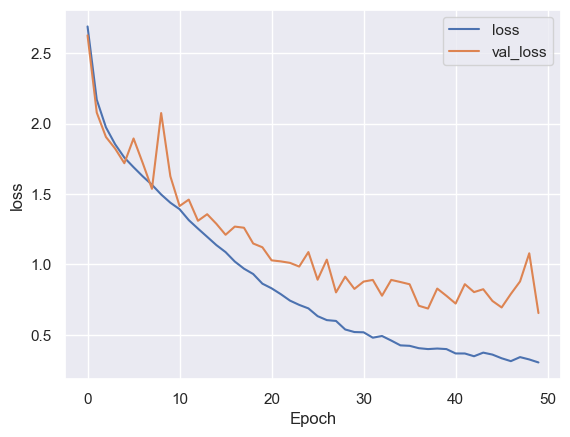

In [405]:
plot_acc_his(history)
plot_loss_his(history)

## Run Below cells

In [5]:
BASE_DIR = '../data/UTKFace/'
age_off = 5
image_paths = []
age_labels = []
gender_labels = []
# file parse part modified from https://www.kaggle.com/code/eward96/age-and-gender-prediction-on-utkface
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
gender_dict = {0:'Male', 1:'Female'}

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)
        img = img.resize((32, 32), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)

    return features

X = extract_features(df['image'])
X = X/255.0

  0%|          | 0/23708 [00:00<?, ?it/s]

  0%|          | 0/23708 [00:00<?, ?it/s]

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_42239/4124293125.py:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((32, 32), Image.ANTIALIAS)


In [7]:
def pred_gender_age_group(idx,gender_batch=32,age_batch=32,gender_epoch=15,age_epoch=50, lr=0.001):
    BASE_DIR = '../data/UTKFace/'

    image_paths = []
    age_labels = []
    gender_labels = []


    age_model = tf.keras.models.load_model("../data/age_model")
    gender_model = tf.keras.models.load_model("../data/gender_model")
    im = X[idx].reshape(1,32,32,3)
    # age group predict
    age_pred = age_model.predict(im)
    i = np.argmax(age_pred.flatten())
    low = age_off * (i-1)
    high = age_off * i
    
    # gender predict
    gender_pred = gender_model.predict(im)
    pred_gender = "male" if gender_pred.flatten()[0] <= 0.5 else "femal"
    true_gender = "male" if df["gender"][idx] ==0 else "femal"
    
    
    # print info 
    print("True gender: ", true_gender)
    print("Predict gender: ", pred_gender)
    print("True Age: ", df['age'][idx])
    print("Predict age group: %d - %d "%(low,high))
    img = Image.open(df['image'].iloc[idx])
    display(img)

  0%|          | 0/23708 [00:00<?, ?it/s]

  0%|          | 0/23708 [00:00<?, ?it/s]

/var/folders/_t/v4x0rpks373cv_vh41d28_800000gn/T/ipykernel_8675/3830668306.py:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((32, 32), Image.ANTIALIAS)


1/1 [==============================] - 0s 75ms/step


2022-11-11 11:35:14.771863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:35:14.887729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 279ms/step
True gender:  male
Predict gender:  male
True Age:  11
Predict age group: 10 - 15 


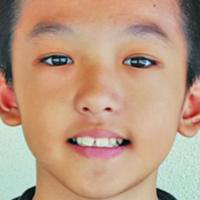

In [9]:
pred_gender_age_group(23000)